In [1]:
%reload_ext autoreload
%autoreload 2

from brian2 import *
from plotlib import *
from tqdm import tqdm

import experiment_10_full_ping_connectome as ex10
import pickle
import scipy.stats as stats


In [2]:
n_mod = 998
#n_mod = 100
start, end = 1000, 5000
dt, shift = 5, 5

In [3]:

def mapper(modulation):
    return ex10.run_experiment(
        n_mod=n_mod,
        with_thalamus=True,
        thalamus_modulation=modulation,
        inter_scaling=50,
    )

p = Pool(4)
modulation = np.linspace(0, 1, 4)
data_array = p.map(mapper, modulation)
p.close()

Setting up synapses... 
Setting up synapses... 
Setting up synapses... 
Setting up synapses... 
	EX_IN_SYN... 	EX_IN_SYN... 	EX_IN_SYN... 	EX_IN_SYN... (279,347 synapses) [1.19s]
(279,347 synapses) [1.19s]
(279,347 synapses) [1.19s]
(279,347 synapses) [1.20s]
	IN_EX_SYN... 	IN_EX_SYN... 	IN_EX_SYN... 	IN_EX_SYN... (399,200 synapses) [1.51s]
(399,200 synapses) [1.52s]
	IN_IN_SYN... 	IN_IN_SYN... (399,200 synapses) [1.54s]
(399,200 synapses) [1.56s]
	IN_IN_SYN... 	IN_IN_SYN... (99,800 synapses) [0.41s]
	INTER_EX_EX_SYN... (99,800 synapses) [0.44s]
(99,800 synapses) [0.42s]
(99,800 synapses) [0.42s]
	INTER_EX_EX_SYN... 	INTER_EX_EX_SYN... 	INTER_EX_EX_SYN... (5,713,198 synapses) [47.85s]
	TH_OUT_SYN... (5,713,198 synapses) [47.91s]
(5,713,198 synapses) [47.93s]
	TH_OUT_SYN... 	TH_OUT_SYN... (5,713,198 synapses) [47.93s]
	TH_OUT_SYN... (801,040 synapses) [6.04s]
	TH_EX_IN_SYN... (801,040 synapses) [5.99s]
	TH_EX_IN_SYN... (6,910 synapses) [0.08s]
	TH_IN_EX_SYN... (801,040 synapses) [6.02s]

In [38]:
len(data_array)

1

In [4]:
lzs = []
lzs = np.zeros((len(data_array), n_mod))
n_steps = float(end - start) / shift

for idx, d in enumerate(data_array):
    sys.stdout.write("{}... ".format(idx))
    sys.stdout.flush()
    lzs[idx,:] = get_lz_comp(d, start, end, dt, shift)
lzs *= np.log(n_steps) / n_steps


0... Separating spikes into modules...  [1.24s]
Calculating LZ complexity of modules...  [4.24s]
1... Separating spikes into modules...  [1.48s]
Calculating LZ complexity of modules...  [5.44s]
2... Separating spikes into modules...  [2.04s]
Calculating LZ complexity of modules...  [5.81s]
3... Separating spikes into modules...  [2.16s]
Calculating LZ complexity of modules...  [7.42s]


In [20]:
with open('experiment_data/exp12_lz.pickle', 'wb') as f:
    pickle.dump(lzs, f)

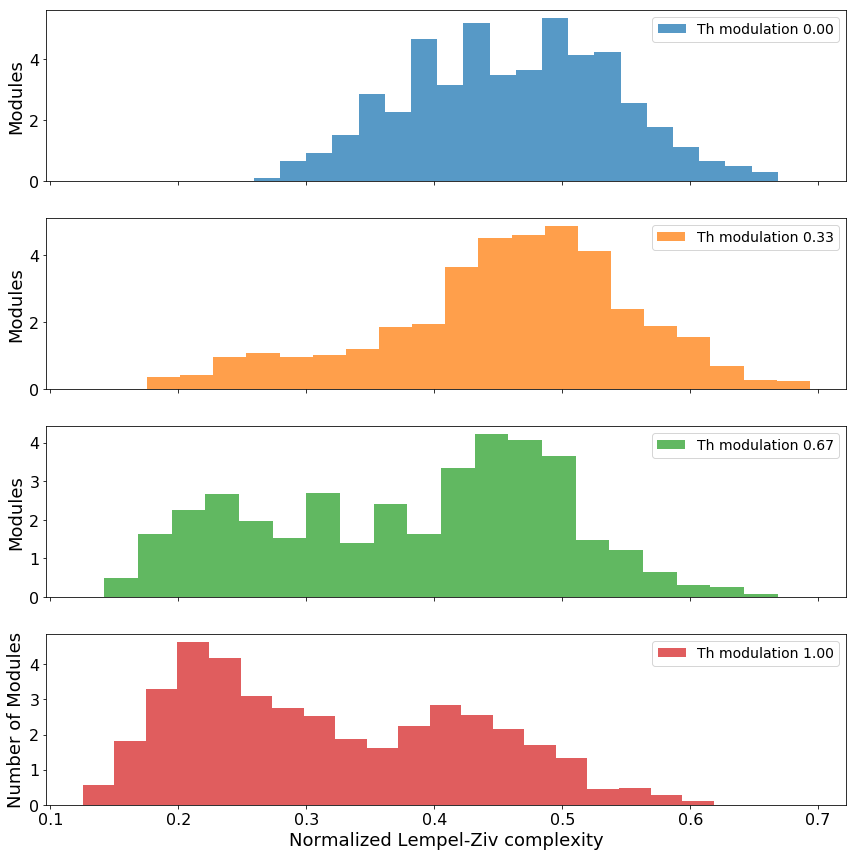

In [5]:
plt.rc('text', usetex=False)


_, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12))
n_steps = float(end - start) / shift
for i, zippedargs in enumerate(zip(lzs, modulation, [ax1, ax2, ax3, ax4])):
    lz_comp, mod, ax = zippedargs
    kwargs = dict(
        histtype='stepfilled',
        alpha=0.75,
        normed=True,
        bins=20,
        label='Th modulation {:.2f}'.format(mod),
        color='C{}'.format(i),
    )
    ax.hist(lz_comp, **kwargs)
    ax.set_ylabel('Modules')
    ax.legend(loc=1)

ax4.set_xlabel('Normalized Lempel-Ziv complexity')
plt.ylabel('Number of Modules')
#for lz_comp, mod in zip(lzs, modulation):
#    plot_lz(lz_comp, start, end, dt, shift, ax=ax, label='Thalamic modulation {:.2f}'.format(mod))
#ax.set_title('LZ complexity of the modules\' dynamics')
plt.tight_layout()
plt.legend()
plt.show()

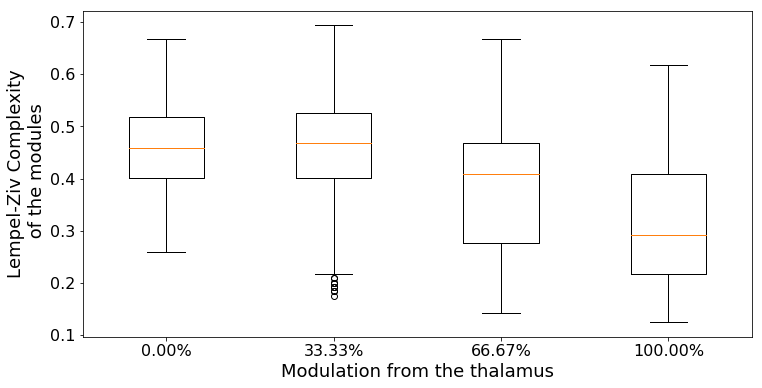

In [6]:
#for l, mod in zip(lzs, modulation):
#    mean = l.mean()
#    std = l.std()
fig, ax = plt.subplots(figsize=(12,6))
ax.boxplot(list(lzs))
ax.set_xticklabels(["{:.2f}%".format(100*mod) for mod in modulation])
ax.set_ylabel('Lempel-Ziv Complexity\n of the modules')
ax.set_xlabel('Modulation from the thalamus')
#ax.set_title('Dynamic complexity with varying modulation from the thalamus')
#plt.savefig('figures/lz_comp_th_modulation.png')
plt.show()

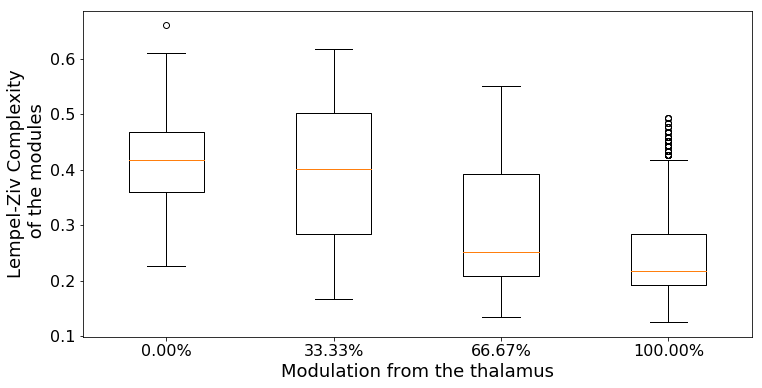

In [55]:
#for l, mod in zip(lzs, modulation):
#    mean = l.mean()
#    std = l.std()
fig, ax = plt.subplots(figsize=(12,6))
ax.boxplot(list(lzs))
ax.set_xticklabels(["{:.2f}%".format(100*mod) for mod in modulation])
ax.set_ylabel('Lempel-Ziv Complexity\n of the modules')
ax.set_xlabel('Modulation from the thalamus')
#ax.set_title('Dynamic complexity with varying modulation from the thalamus')
#plt.savefig('figures/lz_comp_th_modulation.png')
plt.show()

## Mann-Whitney U Test

In [10]:

for i, (x, y) in enumerate(zip(lzs, lzs[1:])):
    mwu = stats.mannwhitneyu(x, y, alternative='greater')
    print("{}, {} -> p-value = {}, U = {}".format(i, i+1, mwu.pvalue, mwu.statistic))

0, 1 -> p-value = 0.789808535134, U = 487633.5
1, 2 -> p-value = 7.37299042488e-50, U = 688476.0
2, 3 -> p-value = 1.82463086178e-33, U = 652427.5


In [84]:
stats.mannwhitneyu(lzs[0], lzs[3], alternative='greater')

MannwhitneyuResult(statistic=911758.5, pvalue=4.8202372915924726e-227)

16,512,067 exc spikes, 10,799,058 inh spikes


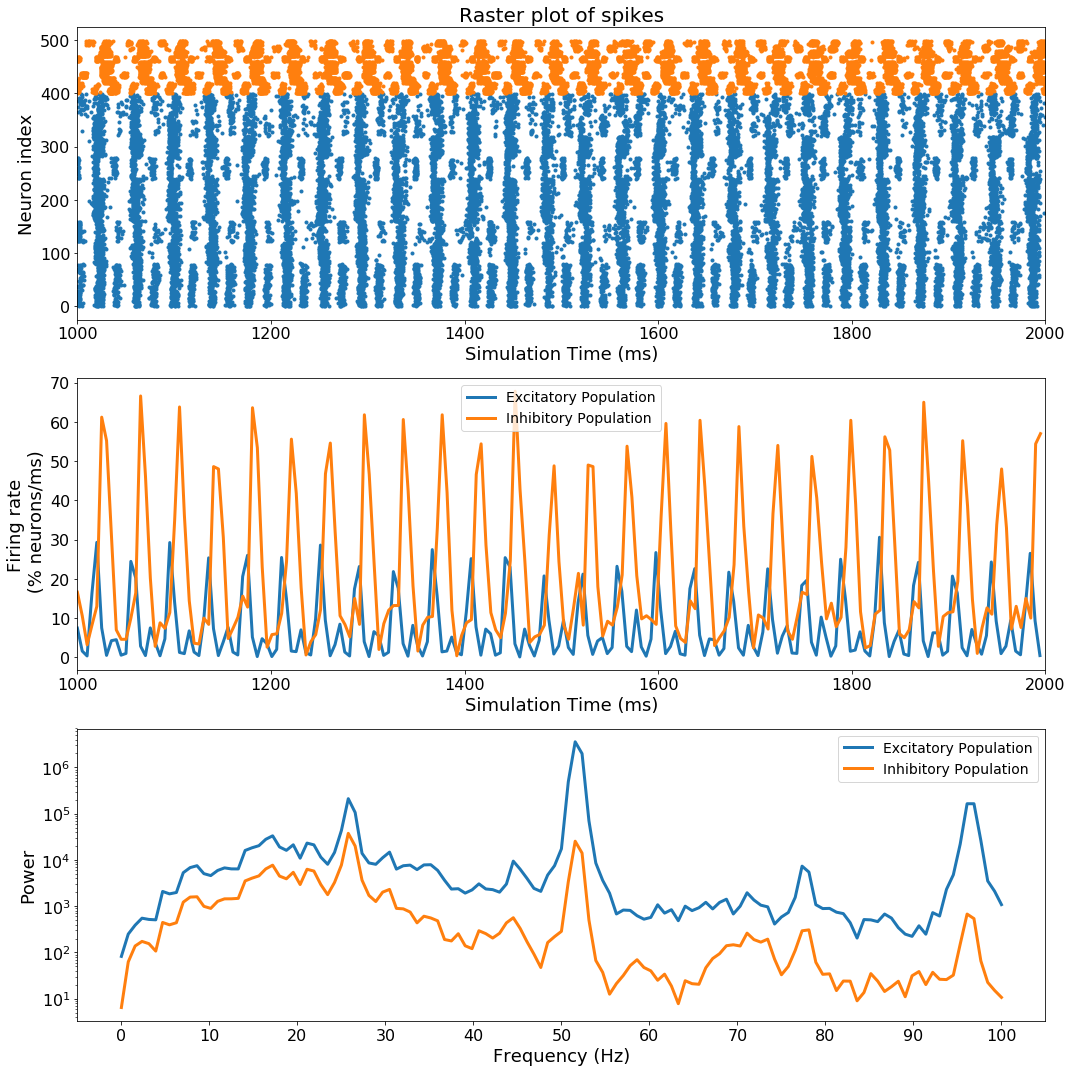

In [11]:
plot_stuff(data_array[3], max_mod=10)

## Thalamus is the only source of input to the network



In [2]:
n_mod = 998
#n_mod = 100
start, end = 1000, 5000
dt, shift = 5, 5

In [3]:

def mapper(modulation):
    return ex10.run_experiment(
        n_mod=n_mod,
        with_thalamus=True,
        thalamus_modulation=modulation,
        inter_scaling=50,
    )

p = Pool(4)
modulation = np.linspace(0, 1, 4)
data_array_2 = p.map(mapper, modulation)
p.close()

Setting up synapses... 
Setting up synapses... 
Setting up synapses... 
Setting up synapses... 
	EX_IN_SYN... 	EX_IN_SYN... 	EX_IN_SYN... 	EX_IN_SYN... (279,347 synapses) [1.19s]
(279,347 synapses) [1.19s]
(279,347 synapses) [1.19s]
(279,347 synapses) [1.20s]
	IN_EX_SYN... 	IN_EX_SYN... 	IN_EX_SYN... 	IN_EX_SYN... (399,200 synapses) [1.51s]
(399,200 synapses) [1.52s]
	IN_IN_SYN... 	IN_IN_SYN... (399,200 synapses) [1.54s]
(399,200 synapses) [1.56s]
	IN_IN_SYN... 	IN_IN_SYN... (99,800 synapses) [0.41s]
	INTER_EX_EX_SYN... (99,800 synapses) [0.44s]
(99,800 synapses) [0.42s]
(99,800 synapses) [0.42s]
	INTER_EX_EX_SYN... 	INTER_EX_EX_SYN... 	INTER_EX_EX_SYN... (5,713,198 synapses) [47.85s]
	TH_OUT_SYN... (5,713,198 synapses) [47.91s]
(5,713,198 synapses) [47.93s]
	TH_OUT_SYN... 	TH_OUT_SYN... (5,713,198 synapses) [47.93s]
	TH_OUT_SYN... (801,040 synapses) [6.04s]
	TH_EX_IN_SYN... (801,040 synapses) [5.99s]
	TH_EX_IN_SYN... (6,910 synapses) [0.08s]
	TH_IN_EX_SYN... (801,040 synapses) [6.02s]